In [2]:
 # Essentials
import os
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Tools/Metrics 
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import scipy

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
path = '/content/drive/MyDrive/CME538 Project 2'
os.chdir(path)

#Exploratory Data Analysis



## Exploring Domain Knowledge

After data wrangling and cleaning, we are left with a dataframe with 1135 entries and 79 features. We must examine the features and assess which are most important to include for a high-performing model.

In [5]:
dpoy_df = pd.read_csv('dpoy_player_team_stats_1984_2022_final.csv').sort_values(by='Year', ascending =False).reset_index(drop = True)
dpoy_df.head()

,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,...,Team_Off-eFG%,Team_Off-TOV%,Team_ORB%,Team_Off-FT/FGA,Team_Def-eFG%,Team_Def-TOV%,Team_DRB%,Team_Def-FT/FGA,Team_Arena,Team_Attend.
0,Ish Wainright,27,PHO,0.0,0.0,0,0.000,45,8.0,2.4,...,0.549,11.6,22.3,0.176,0.510,13.0,77.1,0.195,Phoenix Suns Arena,"663,171"
1,D.J. Wilson,25,TOR,0.0,0.0,0,0.000,4,13.5,7.5,...,0.510,11.0,28.4,0.177,0.535,14.4,75.6,0.199,Scotiabank Arena,"547,343"
2,Robert Williams,24,BOS,1.0,8.0,500,0.016,61,29.6,10.0,...,0.542,12.4,24.0,0.195,0.502,12.5,77.3,0.183,TD Garden,"785,396"
3,Al Horford,35,BOS,0.0,3.0,500,0.006,69,29.1,10.2,...,0.542,12.4,24.0,0.195,0.502,12.5,77.3,0.183,TD Garden,"785,396"
4,Draymond Green,31,GSW,0.0,2.0,500,0.004,46,28.9,7.5,...,0.552,13.5,22.8,0.181,0.509,13.0,78.7,0.201,Chase Center,"740,624"


After researching the characteristics of past Defensive Player of the Year candidates, it is clear that the award has been received mostly by larger players (like those in the position of Power Forward and Center) who excel at both blocking and rebounding shots on defense. We explore the relationship between share and these statistics below to confirm the accuracy if blocking and rebounding are considered highly in the awarding of share. Additionnally, we will indicate what positions each players are through a color scheme.

Text(28.921093749999997, 0.5, 'Defensive Rebounds per Game')

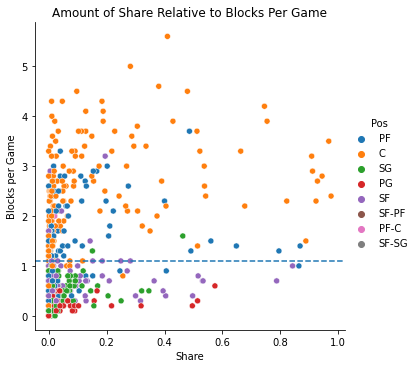

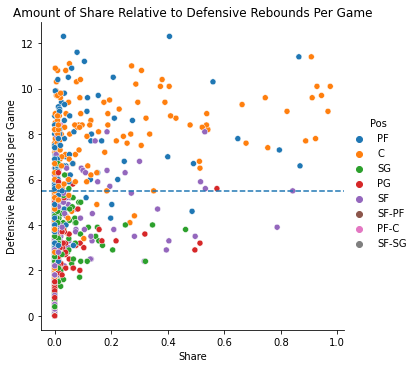

In [6]:
temp = dpoy_df.copy()
ax = sns.relplot(data = temp, x = "Share", y = "BLK", hue = 'Pos')
plt.axhline(temp['BLK'].quantile(0.75), ls = '--') #Add a line to show the 75th percentile of blocks per game among players.
plt.title('Amount of Share Relative to Blocks Per Game')
plt.xlabel('Share')
plt.ylabel('Blocks per Game')

ax = sns.relplot(data = temp, x = "Share", y = "DRB", hue = 'Pos')
plt.axhline(temp['DRB'].quantile(0.75), ls = '--') #Add a line to show the 75th percentile of defensive rebounds per game among players.
plt.title('Amount of Share Relative to Defensive Rebounds Per Game')
plt.xlabel('Share')
plt.ylabel('Defensive Rebounds per Game')

It is clear that in the dataset years, a majority of the players that receive share are part of this 'big man' category of players who excel at blocking and rebounding shots on defense.

However, there are players in traditionally smaller positions (e.g. SG: Shooting Guard, PG: Point Guard, SF: Small Forward) that are receiving notable share but do not seem to be proficient in either of these statistics. Another common statistic noted by media for justifying smaller players as defensively sound is the number of steals they perform per game. A steal is when a defensive player legally causes a turnover by their positive, aggressive action, and it is more common for these smaller players to have higher steals because they are more agile and able to disrupt the opposing players using this speed. We confirm the importance of steals to share below.

Text(29.51354166666666, 0.5, 'Steals per Game')

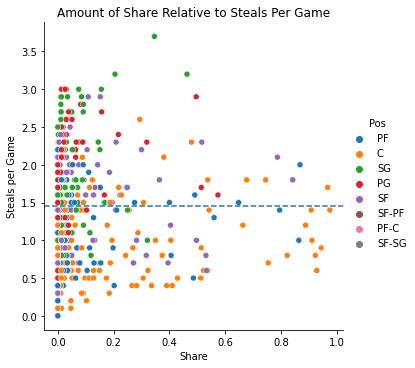

In [7]:
ax = sns.relplot(data = temp, x = "Share", y = "STL", hue = 'Pos')
plt.axhline(temp['STL'].quantile(0.75), ls = '--') #Add a line to show the 75th percentile of steals per game among players.
plt.title('Amount of Share Relative to Steals Per Game')
plt.xlabel('Share')
plt.ylabel('Steals per Game')

As discussed above, players outside of the larger positions that are receiving notable share have a common characteristic of tallying higher number of steals. 

Due to the multi-faceted assessment involved in awarding votes to the defensive player of the year candidate, it is important that the model considers factors that show the defensive capability of both larger and smaller players. It will be easy to achieve a high model performance using only statistics that measure the proficiency of large players because they make the majority of past players who received share, but we will try to consider statistics that favor smaller players as well.

To conclude our discussion of the differences between smaller and larger positions, we provide simple plots of blocks vs steals and rebounds vs steals.

Text(28.921093749999997, 0.5, 'Defensive Rebounds per Game')

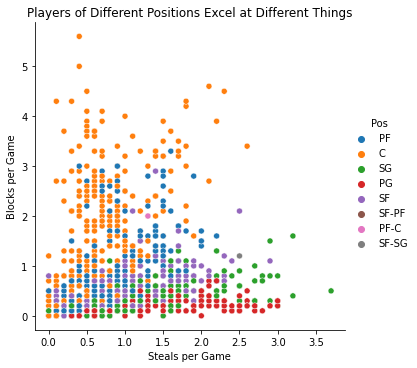

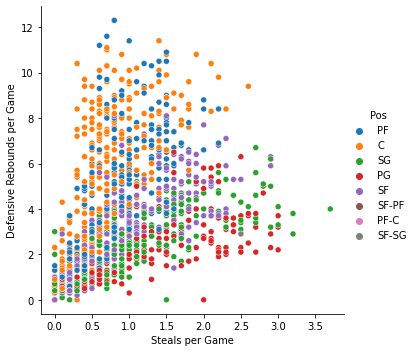

In [8]:
sns.relplot(y="BLK", x="STL", hue = 'Pos', data=dpoy_df)
plt.title('Players of Different Positions Excel at Different Things')
plt.xlabel('Steals per Game')
plt.ylabel('Blocks per Game')
sns.relplot(y="DRB", x="STL", hue = 'Pos', data=dpoy_df)
plt.xlabel('Steals per Game')
plt.ylabel('Defensive Rebounds per Game')

## Feature Selection
The statistics provided by Basketball Reference are detailed and robust enough to focus more attention on feature selection. We will separate the data from 2022 to use as our test dataset, with the data from the remaining years (1984-2021) for use in our training dataset.

In [10]:
# train_df = dpoy_df[(dpoy_df['Year'] < 2022) & (dpoy_df['Share'] > 0) ] --> Used this training set to see how models would perform with no undersampling
train_df = dpoy_df[(dpoy_df['Year'] < 2022)]
test_df = dpoy_df[dpoy_df['Year'] >= 2022]

Our final dataframe has close to 80 features and filtering out a majority of them will be difficult using domain knowledge alone. We will use the feature utility metric of Mutual Information to quantitatively assess which features are more useful for predicting the amount of share a player will receive based on their own and team statistics during the season.

Mutual information measures the relationship between two quantities, but has the distinct advantage of being able to identify more than just linear relationships, unlike correlation. It describes these relationships using 'uncertainty'; it measures the extent that the knowledge of one quantity reduces the uncertainty of the other. A mutual information score of 0 represents zero correlation between two variables (i.e. knowing the state of one of the variables provides no information about the state of the other). We will thus aim to use features with a high mutual information score that also make sense within the domain knowledge we have.

We begin our feature selection process by plotting the mutual information scores of all features corresponding to their relationship with 'share'.

In [11]:
def calculate_ml_scores(df):
    '''
    Calculate the Mutual Information scores of the features in df relative to their relationship with the target variable, 'Share'.
    Input:
      df: dataframe with target variable "Share" and other columns representing features to be measured using Mutual Information.
    Output:
      X: dataframe without "Share"
      y: "Share" series.
      mi_scores (series): Mutual Information Scores sorted largest to smallest.
    '''
    X = df.copy()
    y = X["Share"]

    X.drop('Share', axis=1, inplace=True)

    # Label encoding for categoricals
    for colname in X.select_dtypes("object"):
        X[colname], _ = X[colname].factorize()

    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = X.dtypes == int
    
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return X, y, mi_scores

In [12]:
df_mi = dpoy_df.copy()
df_mi.drop(['Player', 'Tm', 'Pos', 'Team_Team','Team_Arena', 'Team_Attend.', #drop features that non-numerical
            'First', 'Pts Won', 'Pts Max'],
            axis=1, inplace=True) #drop features that result from the share variable, preventing data leakage

In [13]:
X, y, mi_scores = calculate_ml_scores(df=df_mi)

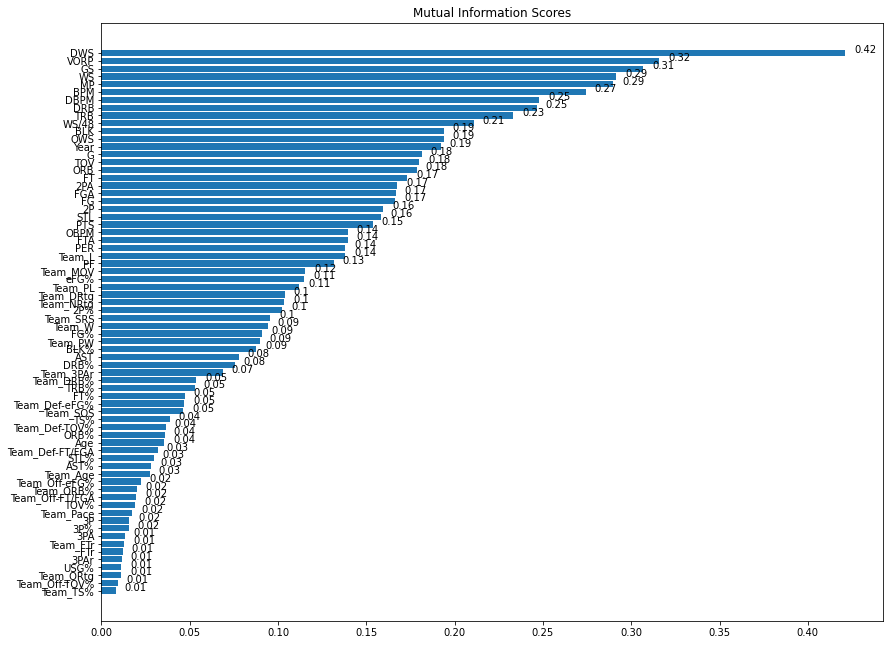

In [14]:
def plot_mi_scores(scores, figsize):
    ''' Function to create bar graph that shows mutual information scores from greatest to least '''
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(width, scores)
    
    for index, value in enumerate(scores):
        plt.text(value +0.005 , index, str(round(value,2)))
    
    plt.yticks(width, ticks)    
    plt.title("Mutual Information Scores")

plot_mi_scores(mi_scores, figsize=(14,11))

It is unsurprising that statistics like defensive rebounds (DRB), blocks (BLK) and steals (STL) are among the top features ranked by mutual information. What about the other features that rank high?

Defensive Win Share attributes credit to players based on their ability to prevent opposing teams from scoring - it makes sense why a player with a high defensive win share statistic would be considered favorably over players with a low score.

The Games Started statistic (GS), Minutes Played statistic (MP), and Games Played statistic (G) provide insight into the consistencies of players to produce their given statistics. It is not uncommon for players to only touch the court for a few minutes every game, and if they are standing in the right place at the right time, they can gather statistics that appear noteworthy. However, we want to our model to favor players who have the consistency to achieve their statistics, thus earning media attention for their efforts.

We believe statistics like box plus-minus (BPM), team defensive rating (Team_DRtg) and team win loss (reflected in team W and team L) are also considered in the nomination of DPOY candidates because players are looked upon favorably if they are a part of a winning team. For example, a player that improves the ability of  the rest of their teammates to make defensive plays and ultimately contributes to a strategy that scores more points than opposing teams will be recognized for their defensive efforts more.

We iteratively checked the performance of selecting different features with a test model. Our objective was to identify the top features that would result in low RMSE and MAE scores, and high R2 scores. We started by assessing our model with all features fed into the training dataset, and iteratively chose features to remove based on if there was a sharp decrease in R2 or sharp increase in RMSE and MAE. We also used a correlation matrix to identify which features are closely associated with one another to remove them from the model.

Our final set of features were selected using our domain knowledge, mutual information scores and iterative checking the model performance. The features selected were:
- 'G' (Games Played)
- 'MP' (Minutes Played)
- 'STL' (Steals)
- 'BLK' (Blocks)
- 'WS/48' (Win/Share per 48 Minutes)
- 'DRB' (Defensive Rebounds)
- 'PF' (Personal Fouls)
- 'VORP' (Value Over Replacement Player)
- 'DWS' (Defensive Win Share)
- 'DBPM' (Defensive Box Plus Minus)
- 'Team_W/L' (Team Win Percentage)
- 'Team_PL' (Team Points Lost)
- 'Team_DRtg' (Team Defensive Rating)

In [15]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data(data):
    """Process the data for a guided model."""
    # Transform Data, Select Features
    pys = data[['Player','Year','Share']]
    data['has_share'] = data['Share'].map(lambda x: int(x > 0))
    data['Team_W/L'] = data['Team_W']/82
    data = select_columns(data, 
                          'Share', 'G', 'MP', 'STL', 'BLK', 'WS/48', 'DRB', 'PF', 'VORP', 'DWS', 'DBPM', 'Team_W/L', 'Team_PL', 'Team_DRtg'
    )
    #Normalization
    for column in data.columns.tolist():
      data[column] = (data[column] - data[column].min())/(data[column].max() - data[column].min())
    X = data.drop(['Share'], axis = 1)
    Y = data.loc[:, 'Share']

    return X, Y, pys

In [16]:
# Set up training and test datasets
X_train, y_train, train_for_accuracy = process_data(train_df)
X_test, y_test, test_for_accuracy = process_data(test_df)

<ipython-input-15-7a3add681a63>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['has_share'] = data['Share'].map(lambda x: int(x > 0))
<ipython-input-15-7a3add681a63>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Team_W/L'] = data['Team_W']/82


For reference, the mutual information scores of these features relative to the target variable 'share' are shown below. The correlation matrix between the features is also provided.

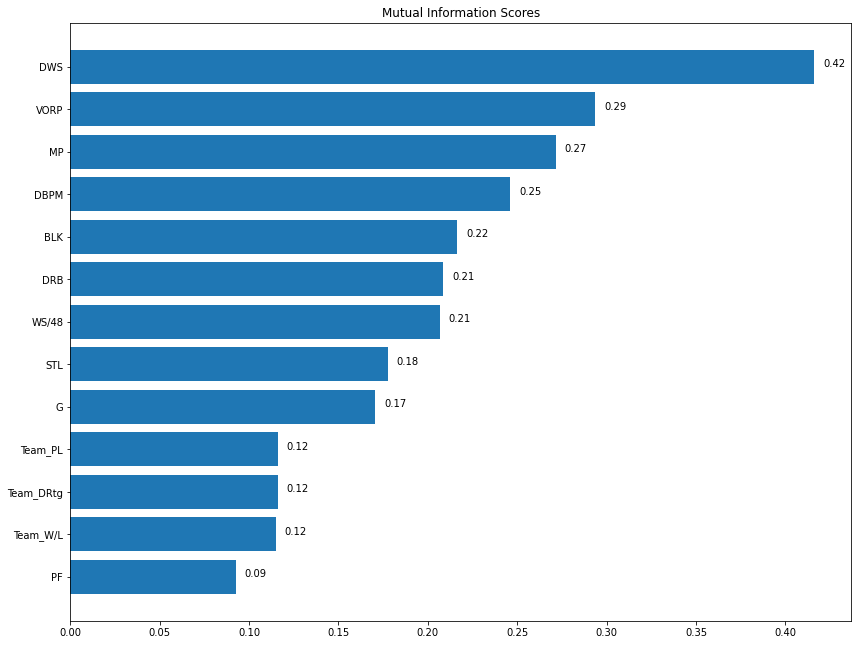

In [23]:
df_mi = X_train.copy()
df_mi['Share'] = y_train
X, y, mi_scores = calculate_ml_scores(df=df_mi)
plot_mi_scores(mi_scores, figsize=(14,11))

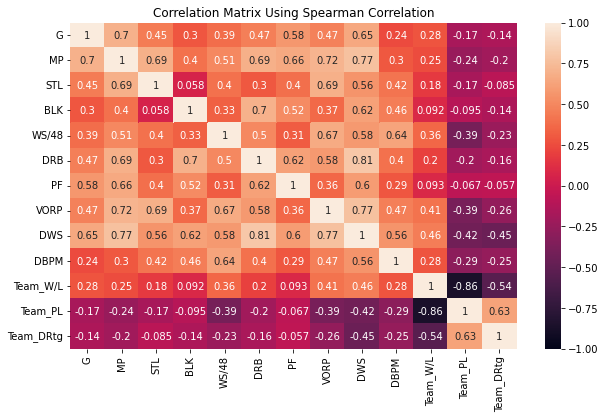

In [24]:
def display_correlation(df, method):
    r = df.corr(method=method)
    plt.figure(figsize=(10,6))
    heatmap = sns.heatmap(df.corr(), vmin=-1, 
                      vmax=1, annot=True)
    plt.title("Correlation Matrix Using Spearman Correlation")
display_correlation(X_train, method = "spearman")

For clarity, the code below lists all columns that were dropped from the original dataframe.

In [25]:
dropped = []
for feature in dpoy_df.columns.tolist():
  if feature not in ['Share', 'G', 'MP', 'STL', 'BLK', 'WS/48', 'GS', 'DRB', 'PF', 'VORP', 'DWS', 'DBPM', 'BPM', 'Team_W/L', 'Team_PL', 'Team_DRtg', 'Team_NRtg', 'Team_Def-eFG%', 'Team_Attend.', 'Position_SG', 'Position_SF', 'Position_PF', 'Position_C']:
      dropped.append(feature)
print("The following columns were dropped from the dataframe:",dropped)

The following columns were dropped from the dataframe: ['Player', 'Age', 'Tm', 'First', 'Pts Won', 'Pts Max', 'PTS', 'TRB', 'AST', 'FG%', '3P%', 'FT%', 'WS', 'Year', 'Pos', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'ORB', 'TOV', 'USG%', 'AST%', 'STL%', 'FTr', 'BLK%', 'DRB%', 'PER', 'OWS', '3PAr', 'ORB%', 'OBPM', 'TS%', 'TRB%', 'TOV%', 'Team_Team', 'Team_Age', 'Team_W', 'Team_L', 'Team_PW', 'Team_MOV', 'Team_SOS', 'Team_SRS', 'Team_ORtg', 'Team_Pace', 'Team_FTr', 'Team_3PAr', 'Team_TS%', 'Team_Off-eFG%', 'Team_Off-TOV%', 'Team_ORB%', 'Team_Off-FT/FGA', 'Team_Def-TOV%', 'Team_DRB%', 'Team_Def-FT/FGA', 'Team_Arena']


# Model Testing, Evaluation, and Selection

Potential Regression Models to be Used:
*   Random Forest
*   XGBoost
*   LightGBM

Metrics to be used to evaluate model:
*   Mean Absolute Error (MAE) --> Want to minimize
*   Root Mean Squared Error (RMSE) --> Want to minimize
*   Coefficient of Determination (R^2) --> Want to maximize
*   Accuracy (In terms of predicting the correct DPOY winner) --> Want to maximize

In [26]:
# Let's create a function that will allow us perform cross-validation on different models to see their different metric scores

from sklearn.model_selection import KFold # Do we want to use KStratifiedFold here, or is regular KFold fine?
from sklearn.base import clone

def cross_validate(model, x, y):

  """ 
  Input:
    Regression model of choice, X train data set (features only), y train data
    set (target variable only)

  Output:
    List of Cross-validation RMSE scores, Mean of Cross-validation RMSE scores,
    List of MAE scores, Mean of MAE scores, List of R2 scores, Mean of R2 scores

  """

  model = clone(model)
  five_fold = KFold(n_splits = 5, shuffle = True, random_state = 0)
  RMSE_scores = []
  MAE_scores = []
  R2_scores = []

  for train_index, val_index in five_fold.split(x,y):
        
        X_train, y_train = x.iloc[train_index], y.iloc[train_index]
        X_val, y_val =  x.iloc[val_index], y.iloc[val_index]
        
        # Fit model
        model.fit(X_train, y_train)
        y_fitted = model.predict(X_train)
        y_predicted = model.predict(X_val)
    
        # Append RMSE, MAE, and R2 scores, using val error
        RMSE_scores.append(mean_squared_error(y.iloc[val_index], y_predicted, squared = False))
        MAE_scores.append(mean_absolute_error(y.iloc[val_index], y_predicted))
        R2_scores.append(r2_score(y.iloc[val_index], y_predicted))

  print('CV RMSE scores: {}\n'.format(RMSE_scores), 'CV RMSE scores mean: {}\n'.format(np.mean(RMSE_scores).round(4)),
        'CV MAE scores: {}\n'.format(MAE_scores), 'CV MAE scores mean: {}\n'.format(np.mean(MAE_scores).round(4)),
        'CV R2 scores: {}\n'.format(R2_scores), 'CV R2 scores mean: {}\n'.format(np.mean(R2_scores).round(4)))

In [27]:
# Accuracy Score Function Pipeline

def model_summary(model, x, y, year):

  model = clone(model)
  model.fit(x, y)
  y_predicted = pd.DataFrame(model.predict(x), index = x.index, columns = ['Predicted Share'])
  DPOY_race = train_for_accuracy[train_for_accuracy['Year'] == year]
  DPOY_race = pd.merge(DPOY_race, y_predicted, left_index = True, right_index = True)
  DPOY_race = DPOY_race.sort_values(['Share', 'Predicted Share'], ascending = (False, False))
  actual_winner = DPOY_race[DPOY_race['Share'] == DPOY_race['Share'].max()]['Player']
  predicted_winner = DPOY_race[DPOY_race['Predicted Share'] == DPOY_race['Predicted Share'].max()]['Player']

  return(predicted_winner.iloc[0], actual_winner.iloc[0])

def model_accuracy(model, x, y):

  years = [year for year in range(1984,2022)]

  predicted_DPOY = []
  actual_DPOY = []
  prediction_label = []

  for year in years:
    predicted_winner, actual_winner = model_summary(model, x, y, year)
    if predicted_winner == actual_winner:
      label = 'Correct'

    else:
      label = 'Incorrect'

    predicted_DPOY.append(predicted_winner)
    actual_DPOY.append(actual_winner)
    prediction_label.append(label)


  model_accuracy_dict = {
      'Year': years,
      'Predicted DPOY': predicted_DPOY,
      'Actual DPOY': actual_DPOY,
      'Label': prediction_label
  }

  model_accuracy_DF = pd.DataFrame(model_accuracy_dict)
  correct_count = model_accuracy_DF['Label'].value_counts().iloc[0]
  incorrect_count = model_accuracy_DF['Label'].value_counts().iloc[1]
  accuracy = correct_count / (correct_count + incorrect_count)

  return(model_accuracy_DF, accuracy)

  

In [28]:
# Let's use the cross_validate function and accuracy score function with the three regression models we want to try out; without any hyperparameter tuning

# Random Forest Regressor --> No HP tuning CV

random_forest = RandomForestRegressor(random_state = 0)
cross_validate(random_forest, X_train, y_train)


CV RMSE scores: [0.09741003119028048, 0.09772871861766821, 0.09175480218292013, 0.11154594287692812, 0.157879260291892]
 CV RMSE scores mean: 0.1113
 CV MAE scores: [0.04964121127741037, 0.04657482517482518, 0.04275002331002332, 0.047404755244755244, 0.06492522144522143]
 CV MAE scores mean: 0.0503
 CV R2 scores: [0.25839539047366955, 0.36660797446244775, 0.3622631433860817, 0.40786817380323037, 0.32018823158412235]
 CV R2 scores mean: 0.3431



In [ ]:
# Random Forest Regressor --> No HP tuning Accuracy

RF_summary_DF, RF_accuracy = model_accuracy(random_forest, X_train, y_train)
RF_accuracy

0.8421052631578947

In [ ]:
RF_summary_DF

,Year,Predicted DPOY,Actual DPOY,Label
0,1984,Mark Eaton,Sidney Moncrief,Incorrect
1,1985,Mark Eaton,Mark Eaton,Correct
2,1986,Alvin Robertson,Alvin Robertson,Correct
3,1987,Michael Cooper,Michael Cooper,Correct
4,1988,Michael Jordan,Michael Jordan,Correct
5,1989,Hakeem Olajuwon,Mark Eaton,Incorrect
6,1990,Hakeem Olajuwon,Dennis Rodman,Incorrect
7,1991,Dennis Rodman,Dennis Rodman,Correct
8,1992,David Robinson,David Robinson,Correct
9,1993,Hakeem Olajuwon,Hakeem Olajuwon,Correct


In [ ]:
# XGB Regressor --> No HP tuning CV

XGB = XGBRegressor(random_state = 0, objective = 'reg:squarederror') 
cross_validate(XGB, X_train, y_train)

CV RMSE scores: [0.09756421191429951, 0.09375703368999987, 0.09270562733448101, 0.11029158100381782, 0.1544774478691831]
 CV RMSE scores mean: 0.1098
 CV MAE scores: [0.04734502669594545, 0.045859940305178544, 0.04237977093499857, 0.047016112886386595, 0.06475115001826853]
 CV MAE scores mean: 0.0495
 CV R2 scores: [0.2560459070809754, 0.41704383514434284, 0.34897734103740585, 0.42111063474636834, 0.34916832043628254]
 CV R2 scores mean: 0.3585



In [ ]:
# XGB Regressor --> No HP tuning Accuracy
XGB_summary_DF, XGB_accuracy = model_accuracy(XGB, X_train, y_train)
XGB_accuracy

0.7368421052631579

In [ ]:
XGB_summary_DF

,Year,Predicted DPOY,Actual DPOY,Label
0,1984,Mark Eaton,Sidney Moncrief,Incorrect
1,1985,Mark Eaton,Mark Eaton,Correct
2,1986,Alvin Robertson,Alvin Robertson,Correct
3,1987,Alvin Robertson,Michael Cooper,Incorrect
4,1988,Michael Jordan,Michael Jordan,Correct
5,1989,Hakeem Olajuwon,Mark Eaton,Incorrect
6,1990,Hakeem Olajuwon,Dennis Rodman,Incorrect
7,1991,David Robinson,Dennis Rodman,Incorrect
8,1992,David Robinson,David Robinson,Correct
9,1993,Hakeem Olajuwon,Hakeem Olajuwon,Correct


In [ ]:
# LightGBM --> No HP tuning CV

LGBM = LGBMRegressor(random_state = 0,objective = 'regression' )
cross_validate(LGBM, X_train, y_train)

CV RMSE scores: [0.09772739716084833, 0.10524949550432743, 0.08819101001124692, 0.10502792637288708, 0.15425928116231782]
 CV RMSE scores mean: 0.1101
 CV MAE scores: [0.050094690114972876, 0.05175345960310731, 0.04137348719614808, 0.05180434641843406, 0.06609726439720799]
 CV MAE scores mean: 0.0522
 CV R2 scores: [0.25355516056535843, 0.2653707303293369, 0.4108409636630974, 0.4750469917776081, 0.35100534637029235]
 CV R2 scores mean: 0.3512



In [ ]:
# LightGBM --> No HP tuning accuracy
LGBM_summary_DF, LGBM_accuracy = model_accuracy(LGBM, X_train, y_train)
LGBM_accuracy

0.9210526315789473

In [ ]:
LGBM_summary_DF

,Year,Predicted DPOY,Actual DPOY,Label
0,1984,Sidney Moncrief,Sidney Moncrief,Correct
1,1985,Mark Eaton,Mark Eaton,Correct
2,1986,Manute Bol,Alvin Robertson,Incorrect
3,1987,Michael Cooper,Michael Cooper,Correct
4,1988,Michael Jordan,Michael Jordan,Correct
5,1989,Hakeem Olajuwon,Mark Eaton,Incorrect
6,1990,Hakeem Olajuwon,Dennis Rodman,Incorrect
7,1991,Dennis Rodman,Dennis Rodman,Correct
8,1992,David Robinson,David Robinson,Correct
9,1993,Hakeem Olajuwon,Hakeem Olajuwon,Correct


In [ ]:
# Let's create a hyperparameter tuning pipeline under each model --> we will use both Random Search to find range of the best parameters,
# then Grid Search to further narrow it down

# Random Forest Regressor - Random Search

cv = KFold(n_splits = 5, shuffle = True, random_state = 0)

rf_n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]

rf_max_features = ['auto', 'sqrt']

rf_max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

min_samples_split = [2,5,10]

min_samples_leaf = [1,2,3,4]

bootstrap = [True, False]

rf_param_random_grid = {'n_estimators': rf_n_estimators,
               'max_features': rf_max_features,
               'max_depth': rf_max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
              
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(random_state = 0),
                  param_distributions = rf_param_random_grid,
                  n_iter = 100, cv = cv, n_jobs = -1)

rf_random_result = rf_random.fit(X_train, y_train)

print(rf_random_result.best_params_)

# This initially gave us the following parameters; 
# {'n_estimators': 267, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}
# We then tried these out, and adjusted some values to see which would result in best output metrics

{'n_estimators': 106, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}


In [ ]:
# Let's use the cross_validate function and accuracy score function with the three regression models we want to try out; with RandomSearch hyper-parameter tuning
# Random Forest Regressor --> Random Search Parameters CV

# random_forest_RS = RandomForestRegressor(random_state = 0, n_estimators= 267, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 90, bootstrap= True)
random_forest_RS = RandomForestRegressor(random_state = 0, n_estimators= 106, min_samples_split= 2, min_samples_leaf= 3, max_features= 'sqrt', max_depth= 110, bootstrap= False)

cross_validate(random_forest_RS, X_train, y_train)

CV RMSE scores: [0.08852677499489207, 0.09650286654587972, 0.08424383937389116, 0.10495964457350923, 0.15621553658090556]
 CV RMSE scores mean: 0.1061
 CV MAE scores: [0.04515492027632385, 0.04517697145621674, 0.03948723299761036, 0.045051070208617386, 0.0638506076732492]
 CV MAE scores mean: 0.0477
 CV R2 scores: [0.38748836566567124, 0.3823981188830655, 0.4623988202138647, 0.4757293452308222, 0.3344403840906581]
 CV R2 scores mean: 0.4085



In [ ]:
# Random Forest Regressor --> RandomSearch tuning Accuracy
RF_RS_summary_DF, RF_RS_accuracy = model_accuracy(random_forest_RS, X_train, y_train)
RF_RS_accuracy

0.8157894736842105

In [ ]:
RF_RS_summary_DF[RF_RS_summary_DF['Label']== 'Incorrect']

,Year,Predicted DPOY,Actual DPOY,Label
0,1984,Mark Eaton,Sidney Moncrief,Incorrect
3,1987,Mark Eaton,Michael Cooper,Incorrect
5,1989,Hakeem Olajuwon,Mark Eaton,Incorrect
6,1990,Hakeem Olajuwon,Dennis Rodman,Incorrect
20,2004,Ben Wallace,Metta World Peace,Incorrect
28,2012,Serge Ibaka,Tyson Chandler,Incorrect
31,2015,Draymond Green,Kawhi Leonard,Incorrect


In [ ]:
# XGB Regressor - Random Search

cv = KFold(n_splits = 5, shuffle = True, random_state = 0)

XGB_n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 11)]

learning_rate = [0.00001,0.0001,0.001,0.01,0.015,0.02,0.05,0.1,0.15,0.2]

XGB_max_depth = [int(x) for x in np.linspace(0, 20, num = 11)]

XGB_subsample = np.arange(0.5,1.0,0.05)

min_child_weight = [1,2,3,4,6,7,8,9,10]

XGB_param_random_grid = {
               'n_estimators': XGB_n_estimators,
               'learning_rate': learning_rate,
               'subsample': XGB_subsample,
               'max_depth': XGB_max_depth,
               'min_child_weight': min_child_weight}
              
XGB_random = RandomizedSearchCV(estimator = XGBRegressor(random_state = 0, objective = 'reg:squarederror'),
                  param_distributions = XGB_param_random_grid,
                  n_iter = 100, cv = cv, n_jobs = -1)

XGB_random_result = XGB_random.fit(X_train, y_train)

print(XGB_random_result.best_params_)

# This initially gave us the following parameters:
# {'subsample': 0.7000000000000002, 'n_estimators': 300, 'min_child_weight': 9, 'max_depth': 6, 'learning_rate': 0.015}
# We then tried these out, and adjusted some values to see which would result in best output metrics

{'subsample': 0.6500000000000001, 'n_estimators': 68, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.1}


In [ ]:
# XGB Regressor --> Random Search Parameters CV

# XGB_rs = XGBRegressor(random_state = 0, objective = 'reg:squarederror', n_estimators= 300, min_child_weight= 3, max_depth= 8, learning_rate= 0.020, subsample=0.8) 
XGB_rs = XGBRegressor(random_state = 0, objective = 'reg:squarederror', n_estimators= 68, min_child_weight= 4, max_depth= 4, learning_rate= 0.1, subsample=0.65)
cross_validate(XGB_rs, X_train, y_train)


CV RMSE scores: [0.09172452508155708, 0.09454180432882389, 0.08383165846206034, 0.10718864990067524, 0.14926078096683862]
 CV RMSE scores mean: 0.1053
 CV MAE scores: [0.04516932098117806, 0.04421224301817256, 0.03855002986648421, 0.04692605660136763, 0.06362379945116442]
 CV MAE scores mean: 0.0477
 CV R2 scores: [0.34243907252892314, 0.40724400454763576, 0.46764660712849504, 0.4532252530665051, 0.3923829779601893]
 CV R2 scores mean: 0.4126



In [ ]:
# XGB Regressor --> RandomSearch tuning Accuracy
XGB_RS_summary_DF, XGB_RS_accuracy = model_accuracy(XGB_rs, X_train, y_train)
XGB_RS_accuracy

0.8157894736842105

In [ ]:
XGB_RS_summary_DF[XGB_RS_summary_DF['Label']== 'Incorrect']

,Year,Predicted DPOY,Actual DPOY,Label
0,1984,Mark Eaton,Sidney Moncrief,Incorrect
2,1986,Manute Bol,Alvin Robertson,Incorrect
3,1987,Mark Eaton,Michael Cooper,Incorrect
6,1990,Hakeem Olajuwon,Dennis Rodman,Incorrect
20,2004,Ben Wallace,Metta World Peace,Incorrect
28,2012,Serge Ibaka,Tyson Chandler,Incorrect
31,2015,Draymond Green,Kawhi Leonard,Incorrect


In [ ]:
# LGBM Regressor - Random Search

cv = KFold(n_splits = 5, shuffle = True, random_state = 0)

LGBM_n_estimators =  [int(x) for x in np.linspace(start = 10, stop = 300, num = 11)]

LGBM_learning_rate = [0.00001,0.0001,0.001,0.01,0.015,0.02,0.05,0.1,0.15,0.2]

LGBM_max_depth = [int(x) for x in np.linspace(0, 30, num = 11)]

lambda_l1 = np.arange(0,0.8,0.05)

lambda_l2 = np.arange(0,0.8,0.05)

extra_trees = [True,False]

LGBM_subsample = np.arange(0.3,1.0,0.05)

bagging_freq = [1,10,15, 20, 25, 30, 40 , 50, 60, 70, 80, 90, 100]

colsample_bytree = np.arange(0.3,1.0,0.05)

num_leaves = np.arange(10,100,10)

boosting = ['gbdt','dart']

drop_rate = np.arange(0.1,0.8,0.1)

skip_drop = np.arange(0,0.7,0.1)

LGBM_param_random_grid = {'n_estimators':LGBM_n_estimators,'max_depth':LGBM_max_depth, 'subsample':LGBM_subsample,
          'colsample_bytree':colsample_bytree,
          'learning_rate': LGBM_learning_rate,
          'num_leaves':num_leaves,
          'boosting':boosting,
          'extra_trees':extra_trees,
          'lambda_l1':lambda_l1,
          'lambda_l2':lambda_l2,
          'bagging_freq':bagging_freq,
          'drop_rate':drop_rate}
              
LGBM_random = RandomizedSearchCV(estimator = LGBMRegressor(ramdom_state = 0,objective = 'regression'),
                  param_distributions = LGBM_param_random_grid,
                  n_iter = 100, cv = cv, n_jobs = -1)

LGBM_random_result = LGBM_random.fit(X_train, y_train)

print(LGBM_random_result.best_params_)

# This initially gave us the following parameters:

# {'subsample': 0.7999999999999998, 'num_leaves': 70, 'n_estimators': 300, 'max_depth': 21, 'learning_rate': 0.15,
#  'lambda_l2': 0.15000000000000002, 'lambda_l1': 0.5, 'extra_trees': False, 'drop_rate': 0.6, 'colsample_bytree': 0.8499999999999999, 
#  'boosting': 'dart', 'bagging_freq': 1}

# We then tried these out, and adjusted some values to see which would result in best output metrics


{'subsample': 0.7999999999999998, 'num_leaves': 70, 'n_estimators': 300, 'max_depth': 21, 'learning_rate': 0.15, 'lambda_l2': 0.15000000000000002, 'lambda_l1': 0.5, 'extra_trees': False, 'drop_rate': 0.6, 'colsample_bytree': 0.8499999999999999, 'boosting': 'dart', 'bagging_freq': 1}


In [ ]:
# LightGBM - Random Search Parameters CV


LGBM_rs = LGBMRegressor(ramdom_state = 0,objective = 'regression', subsample= 0.80, num_leaves= 70, n_estimators= 400, max_depth= 21, learning_rate= 0.15, lambda_l2= 0.15000000000000002, lambda_l1= 0.5, extra_trees= False, drop_rate= 0.6, colsample_bytree= 0.8499999999999999, boosting= 'dart', bagging_freq= 1)
cross_validate(LGBM_rs, X_train, y_train)

CV RMSE scores: [0.09459029344253728, 0.10175022015441962, 0.08671226561681676, 0.10176378028147254, 0.1553474965607245]
 CV RMSE scores mean: 0.108
 CV MAE scores: [0.04955380231587491, 0.048571595094581005, 0.03976303034476718, 0.04699770867934423, 0.06542177992592557]
 CV MAE scores mean: 0.0501
 CV R2 scores: [0.300708577441574, 0.3134077493029961, 0.43043279190625394, 0.5071698034917089, 0.3418164397320408]
 CV R2 scores mean: 0.3787



In [ ]:
# LGBM Regressor --> RandomSearch tuning Accuracy
LGBM_RS_summary_DF, LGBM_RS_accuracy = model_accuracy(LGBM_rs, X_train, y_train)
LGBM_RS_accuracy

0.9210526315789473

In [ ]:
LGBM_RS_summary_DF[LGBM_RS_summary_DF['Label']== 'Incorrect']

,Year,Predicted DPOY,Actual DPOY,Label
3,1987,Mark Eaton,Michael Cooper,Incorrect
6,1990,Hakeem Olajuwon,Dennis Rodman,Incorrect
32,2016,Draymond Green,Kawhi Leonard,Incorrect


In [ ]:
# Now we test out our final model on the test dataset, to predict the 2022 DPOY winner

# First, with Random Forest Regressor
random_forest_RS.fit(X_train, y_train)
y_predicted_test_RF = random_forest_RS.predict(X_test)

# RMSE, MAE, and R2 scores  

print('RMSE score: {}\n'.format(mean_squared_error(y_test, y_predicted_test_RF, squared = False).round(4)),
        'MAE score: {}\n'.format(mean_absolute_error(y_test, y_predicted_test_RF).round(4)),
        'R2 score: {}\n'.format(r2_score(y_test, y_predicted_test_RF).round(4)))

 # Accuracy 
y_predicted_test_RF_DF = pd.DataFrame(y_predicted_test_RF, index = X_test.index, columns = ['Predicted Share'])
DPOY_race_RF = test_for_accuracy[test_for_accuracy['Year'] == 2022]
DPOY_race_RF = pd.merge(DPOY_race_RF, y_predicted_test_RF_DF, left_index = True, right_index = True)
DPOY_race_RF = DPOY_race_RF.sort_values(['Share', 'Predicted Share'], ascending = (False, False))
actual_winner_RF = DPOY_race_RF[DPOY_race_RF['Share'] == DPOY_race_RF['Share'].max()]['Player']
predicted_winner_RF = DPOY_race_RF[DPOY_race_RF['Predicted Share'] == DPOY_race_RF['Predicted Share'].max()]['Player']




RMSE score: 0.215
 MAE score: 0.1342
 R2 score: 0.2085



In [ ]:
RF_test = DPOY_race_RF.sort_values(['Predicted Share'], ascending = [False]).reset_index(drop=True)
RF_test 

,Player,Year,Share,Predicted Share
0,Rudy Gobert,2022,0.272,0.541417
1,Al Horford,2022,0.006,0.487085
2,Giannis Antetokounmpo,2022,0.116,0.450963
3,Robert Williams,2022,0.016,0.425605
4,Bam Adebayo,2022,0.256,0.407449
5,Draymond Green,2022,0.004,0.360642
6,Mikal Bridges,2022,0.404,0.354270
7,Jaren Jackson Jr.,2022,0.198,0.326503
8,Marcus Smart,2022,0.514,0.320071
9,JaVale McGee,2022,0.000,0.300845


In [ ]:
# Now we test out our final model on the test dataset, to predict the 2022 DPOY winner

# XGB Regressor
XGB_rs.fit(X_train, y_train)
y_predicted_test_XGB = XGB_rs.predict(X_test)

# RMSE, MAE, and R2 scores  

print('RMSE score: {}\n'.format(mean_squared_error(y_test, y_predicted_test_XGB, squared = False).round(4)),
        'MAE score: {}\n'.format(mean_absolute_error(y_test, y_predicted_test_XGB).round(4)),
        'R2 score: {}\n'.format(r2_score(y_test, y_predicted_test_XGB).round(4)))

 # Accuracy 
y_predicted_test_XGB_DF = pd.DataFrame(y_predicted_test_XGB, index = X_test.index, columns = ['Predicted Share'])
DPOY_race_XGB = test_for_accuracy[test_for_accuracy['Year'] == 2022]
DPOY_race_XGB = pd.merge(DPOY_race_XGB, y_predicted_test_XGB_DF, left_index = True, right_index = True)
DPOY_race_XGB = DPOY_race_XGB.sort_values(['Share', 'Predicted Share'], ascending = (False, False))
actual_winner_XGB = DPOY_race_XGB[DPOY_race_XGB['Share'] == DPOY_race_XGB['Share'].max()]['Player']
predicted_winner_XGB = DPOY_race_XGB[DPOY_race_XGB['Predicted Share'] == DPOY_race_XGB['Predicted Share'].max()]['Player']



RMSE score: 0.2744
 MAE score: 0.1813
 R2 score: -0.2887



In [ ]:
# Predicted Ranking:
XGB_test = DPOY_race_XGB.sort_values(['Predicted Share'], ascending = [False]).reset_index(drop=True)
XGB_test

,Player,Year,Share,Predicted Share
0,Rudy Gobert,2022,0.272,0.910371
1,Robert Williams,2022,0.016,0.627150
2,Giannis Antetokounmpo,2022,0.116,0.583990
3,Al Horford,2022,0.006,0.579813
4,Bam Adebayo,2022,0.256,0.539943
5,Jimmy Butler,2022,0.000,0.465939
6,Matisse Thybulle,2022,0.002,0.459167
7,Jrue Holiday,2022,0.012,0.454772
8,Jaren Jackson Jr.,2022,0.198,0.447177
9,Draymond Green,2022,0.004,0.446821


In [ ]:
# Now we test out our final model on the test dataset, to predict the 2022 DPOY winner

# LGBM Regressor
LGBM_rs.fit(X_train, y_train)
y_predicted_test_LGBM = LGBM_rs.predict(X_test)

# RMSE, MAE, and R2 scores  

print('RMSE score: {}\n'.format(mean_squared_error(y_test, y_predicted_test_LGBM, squared = False).round(4)),
        'MAE score: {}\n'.format(mean_absolute_error(y_test, y_predicted_test_LGBM).round(4)),
        'R2 score: {}\n'.format(r2_score(y_test, y_predicted_test_LGBM).round(4)))

 # Accuracy 
y_predicted_test_LGBM_DF = pd.DataFrame(y_predicted_test_LGBM, index = X_test.index, columns = ['Predicted Share'])
DPOY_race_LGBM = test_for_accuracy[test_for_accuracy['Year'] == 2022]
DPOY_race_LGBM = pd.merge(DPOY_race_LGBM, y_predicted_test_LGBM_DF, left_index = True, right_index = True)
DPOY_race_LGBM = DPOY_race_LGBM.sort_values(['Share', 'Predicted Share'], ascending = (False, False))
actual_winner_LGBM = DPOY_race_LGBM[DPOY_race_LGBM['Share'] == DPOY_race_LGBM['Share'].max()]['Player']
predicted_winner_LGBM = DPOY_race_LGBM[DPOY_race_LGBM['Predicted Share'] == DPOY_race_LGBM['Predicted Share'].max()]['Player']



RMSE score: 0.2345
 MAE score: 0.155
 R2 score: 0.0583



In [ ]:
# Predicted Ranking:
LGBM_test = DPOY_race_LGBM.sort_values(['Predicted Share'], ascending = [False]).reset_index(drop=True)
LGBM_test

,Player,Year,Share,Predicted Share
0,Rudy Gobert,2022,0.272,0.692580
1,Jaren Jackson Jr.,2022,0.198,0.627609
2,Al Horford,2022,0.006,0.596593
3,Giannis Antetokounmpo,2022,0.116,0.542741
4,Draymond Green,2022,0.004,0.483432
5,Robert Williams,2022,0.016,0.475324
6,Mikal Bridges,2022,0.404,0.474330
7,Bam Adebayo,2022,0.256,0.456081
8,Marcus Smart,2022,0.514,0.454729
9,Matisse Thybulle,2022,0.002,0.408582
